# Scikit-Learn IRIS Model using jsonData

**Goal**: Wrap a scikit-learn python model for use as a prediction microservice in seldon-core

#### Steps

1. Run locally on Docker to test
2. Deploy on seldon-core running on a kubernetes cluster

#### Issues

1. User has to write variable names multiple times... very error prone.
2. Wish there was f-strings for YAML cells.

#### Setup Python

In [124]:
%%writefile requirements.txt
scikit-learn
dill
pandas
sklearn
seldon-core
requests
matplotlib

Overwriting requirements.txt


In [6]:
!if [ ! -d "./venv" ]; then python -m venv venv; fi

In [7]:
!source ./venv/bin/activate

In [8]:
!if [ ! -d "/home/jovyan/.config/pip" ]; then mkdir /home/jovyan/.config/pip; fi

In [9]:
%%writefile /home/jovyan/.config/pip/pip.conf
[global]
index-url = https://jfrog.aaw.cloud.statcan.ca/artifactory/api/pypi/pypi-remote/simple

Overwriting /home/jovyan/.config/pip/pip.conf


In [125]:
%%capture
!pip install -r requirements.txt

In [12]:
!python -m ipykernel install --user --name=sklearn_iris_jsondata

Installed kernelspec sklearn_iris_jsondata in /etc/share/jupyter/kernels/sklearn_iris_jsondata


In [129]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

#### Create a seldon config file to deploy the containerized image you just created

In [74]:
%%writefile sklearn_iris_jsondata_deployment.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: seldon-deployment-example
  namespace: bryanpaget
spec:
  name: sklearn-iris-deployment
  annotations:
    sidecar.istio.io/inject: "false"
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: seldonio/sklearn-iris:0.3
          imagePullPolicy: IfNotPresent
          name: sklearn-iris-classifier
    graph:
      children: []
      endpoint:
        type: REST
      name: sklearn-iris-classifier
      type: MODEL
    name: sklearn-iris-predictor
    replicas: 1

Overwriting sklearn_iris_jsondata_deployment.yaml


In [14]:
!kubectl create -f sklearn_iris_jsondata_deployment.yaml

Error from server (AlreadyExists): error when creating "sklearn_iris_jsondata_deployment.yaml": seldondeployments.machinelearning.seldon.io "seldon-deployment-example" already exists


In [15]:
!kubectl rollout status deploy $(kubectl get deploy -l seldon-deployment-id=seldon-deployment-example -o jsonpath='{.items[0].metadata.name}')

deployment "seldon-92a927e5e90d7602e08ba9b9304f70e8" successfully rolled out


### Test by sending prediction calls

#### Is the service available?

In [16]:
for i in range(60):
    state = !kubectl get sdep seldon-deployment-example -o jsonpath='{.status.state}'
    state = state[0]
    print(state)
    if state == "Available":
        break
    time.sleep(1)
assert state == "Available"

Available


In [150]:
res =! curl -v seldon-deployment-example-sklearn-iris-predictor.bryanpaget.svc.cluster.local:8000/api/v0.1/predictions \
   -H 'Content-Type: application/json' \
   -d '{"data": {"ndarray": [[15.964, 1.006, 2.081, 1.031]]}}'

In [151]:
parsed = json.loads(res[-1])
print(json.dumps(parsed, indent=4, sort_keys=True))

{
    "data": {
        "names": [
            "t:0",
            "t:1",
            "t:2"
        ],
        "ndarray": [
            [
                0.48143974601236916,
                0.5185602538736087,
                1.1402208742877527e-10
            ]
        ]
    },
    "meta": {
        "requestPath": {
            "sklearn-iris-classifier": "seldonio/sklearn-iris:0.3"
        }
    }
}


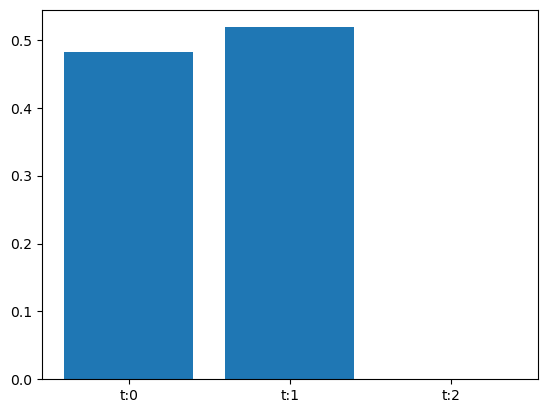

In [152]:
def display_iris_classifier_results(res):
    results = res[-1]
    results = json.loads(results)
    names = results["data"]["names"]
    predictions = results["data"]["ndarray"][0]
    model = results["meta"]["requestPath"]

    df = pd.DataFrame({"x": names, "y": predictions})

    plt.bar(x=names, height=predictions)
    plt.show()

display_iris_classifier_results(res)

In [153]:
!kubectl delete -f sklearn_iris_jsondata_deployment.yaml

seldondeployment.machinelearning.seldon.io "seldon-deployment-example" deleted
